<a href="https://colab.research.google.com/github/Dipon12/DeepFake-using-DCGAN-Architecture-Keras-Implementation/blob/master/DeepFake_using_DCGAN_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt



from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose,Reshape,LeakyReLU
from tensorflow.keras.models import Model,Sequential

print(tf.__version__)

2.2.0-rc3


In [0]:
from tensorflow.keras.datasets import mnist

(X_train_all,Y_train_all),(X_test_all,Y_test_all) = mnist.load_data()



11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train_all[3].shape

(28, 28)

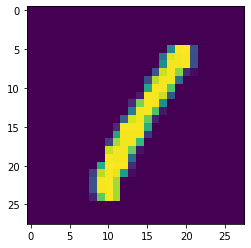

In [0]:
plt.imshow(X_train_all[3])

In [0]:
print("X_train_all Shape: {}".format(X_train_all.shape))
print("Y_train_all Shape: {}".format(Y_train_all.shape))

X_train_all Shape: (60000, 28, 28)
Y_train_all Shape: (60000,)


In [0]:
X_train = []
Y_train = []

for i in range(len(Y_train_all)):
  if Y_train_all[i] == 0:
    X_train.append(X_train_all[i])
    Y_train.append(Y_train_all[i])

In [0]:
X_train = np.array(X_train)/255.0
Y_train = np.array(Y_train)/255.0

In [0]:
print("X_train Shape: {}".format(X_train.shape))
print("Y_train Shape: {}".format(Y_train.shape))

X_train Shape: (5923, 28, 28)
Y_train Shape: (5923,)


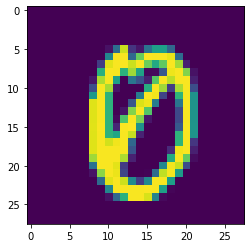

In [0]:
plt.imshow(X_train[501])

In [0]:
discriminator = Sequential ([
      
      Conv2D(64, (3,3), strides=(2,2), input_shape=(28,28,1)),
      LeakyReLU(),
      BatchNormalization(),

      Conv2D(128, (5,5), strides=(2,2)),
      LeakyReLU(),
      BatchNormalization(),

      Conv2D(256, (5,5), strides=(2,2)),
      LeakyReLU(),
      BatchNormalization(),

      Flatten(),
      Dense(1, activation='sigmoid')

])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

In [0]:
generator = Sequential([
      
      Dense(256, activation='relu', input_shape=(1,)),
      Reshape((1,1,256)),

      Conv2DTranspose(256, (5,5), activation='relu' ),
      BatchNormalization(),

      Conv2DTranspose(128, (5,5), activation='relu' ),
      BatchNormalization(),

      Conv2DTranspose(64, (5,5), strides=(2,2), activation='relu' ),
      BatchNormalization(),

      Conv2DTranspose(32, (5,5), activation='relu' ),
      BatchNormalization(),

      Conv2DTranspose(1, (4,4), activation='sigmoid')

])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

In [0]:
noise = np.random.randn(1,1)
gen_image = generator.predict(noise)[0]
print(gen_image.shape)




(28, 28, 1)


In [0]:
input_layer = tf.keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

GAN_model = Model(inputs=input_layer,
                  outputs = disc_out,
                  )

discriminator.trainable= False

GAN_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
GAN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


In [0]:
mini_batch_epoch = 3
batch_size = 128 # half of this is from our training and half of this is from generator
batch_epoch =40
generated_samples = []

for e in range(batch_epoch):

  print("Epoch No. {}/{}".format(e,batch_epoch))

  for batch_no in range(int(X_train.shape[0]/batch_size)):

    print("Batch No. {}/{}".format(batch_no,int(X_train.shape[0]/batch_size)))

    true_examples = X_train[batch_no*int(batch_size/2) : (batch_no+1)*int(batch_size/2)] # as half of this is from generator
    true_examples = np.expand_dims(true_examples,axis=3)
    print(true_examples.shape)
    

    noise = np.random.randn(int(batch_size/2),1)
    generated_examples = generator.predict(noise) #(64,28,28,1)
    print(generated_examples.shape)

    x_batch = np.concatenate([generated_examples,true_examples],axis=0)
    y_batch = np.concatenate([np.zeros((int(batch_size/2))),np.ones((int(batch_size/2)))],axis=0)

    indices = np.random.choice(range(batch_size), size = batch_size, replace= False)
    x_batch = x_batch[indices]
    y_batch = y_batch[indices]

    discriminator.trainable = True
    discriminator.fit(x_batch,y_batch,batch_size=16,epochs=3)
    discriminator.trainable = False

    GAN_model.fit(noise, np.ones((int(batch_size/2),1)),batch_size=32,epochs=mini_batch_epoch)

  new_in = np.random.randn(1,1)
  generated_sample = generator.predict(new_in)
  generated_samples.append(generated_sample)






Streaming output truncated to the last 5000 lines.
Epoch 1/3
8/8 [==============================] - 0s 3ms/step - loss: 0.3975 - accuracy: 0.8750
Epoch 2/3
8/8 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9922
Epoch 3/3
8/8 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 1/3
2/2 [==============================] - 0s 5ms/step - loss: 20.6595 - accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 0s 4ms/step - loss: 17.8596 - accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 0s 5ms/step - loss: 15.2168 - accuracy: 0.0000e+00
Batch No. 36/46
(64, 28, 28, 1)
(64, 28, 28, 1)
Epoch 1/3
8/8 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.8438
Epoch 2/3
8/8 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.9766
Epoch 3/3
8/8 [==============================] - 0s 3ms/step - loss: 0.0529 - accuracy: 0.9922
Epoch 1/3
2/2 [================

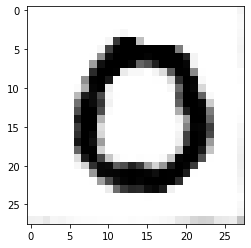

In [0]:
#plt.imshow(np.reshape(generated_samples[0],(28,28,1)))
plt.imshow(np.reshape(generated_samples[39], (28, 28)), cmap='binary')